# Comparing the fidelity of different decompositions methods
- **Authors:** Andrea Barletta, Yanlong Wang
- **Abstract:** In our project we will compare the fidelity of three different architectures for universal multiport interferometers, used to perform any unitary or linear transformation. In particular we will focus on comparing the traditional Reck and Clements architectures with a Universal Generalized Mach–Zehnder Interferometer (UGMZI) architecture inired by the work of P. Dita 

## Global stuff

### Imports

In [1]:
import numpy as np
from scipy.linalg import cossin
from scipy.stats import unitary_group
from matplotlib import pyplot as plt

### Matrix representation of MZI

In [2]:
def U2MZI(dim, m, n, phi, theta, LN=1):
    mat = np.eye(dim, dtype=np.complex128)
    mat[m, m] = np.sqrt(LN) * 1j * np.exp(1j * phi) * np.sin(theta)
    mat[m, n] = 1j * np.cos(theta)
    mat[n, m] = 1j * np.exp(1j * phi) * np.cos(theta)
    mat[n, n] = -np.sqrt(LN) * 1j * np.sin(theta)
    return mat

### Helper functions

In [3]:
def angle_diff(comp_src, comp_dst, offset=0):
    return np.mod(np.angle(comp_dst) - np.angle(comp_src) + offset, 2*np.pi)

## Reck's Method
**References**

Reck, Michael, et al. "Experimental realization of any discrete unitary operator." Physical review letters 73.1 (1994): 58.    

Given a Unitary NxN matrix, we will decompose it to obtain the following circuit topology 

<p align="center">
    <img src="reck.png" width="50%"/>
</p>

<p align="center">
  <img src="" />
</p>

In [4]:
def decompose_reck(u):
    mat = u.copy().astype(np.complex128)
    dim = mat.shape[0]
    num = int(dim * (dim - 1) / 2)
    phis = np.zeros(num)
    thetas = np.zeros(num)
    alphas = np.zeros(dim)
    index = 0
    for p in range(1, dim):
        x = dim - p
        for q in range(dim-p, 0, -1):
            y = q - 1
            thetas[index] = np.pi/2 - \
                np.arctan2(np.abs(mat[x, y]), np.abs(mat[x, x]))
            phis[index] = angle_diff(mat[x, x], mat[x, y], offset=np.pi)
            mat = mat @ U2MZI(dim, y, x, phis[index], thetas[index]).conj().T
            index += 1
    for i in range(dim):
        alphas[i] = np.angle(mat[i, i])
    return phis, thetas, alphas

In [5]:
def reconstruct_reck(phis, thetas, alphas, LN_dB=0):
    num = thetas.squeeze().shape[0]
    dim = int((1 + np.sqrt(1 + 8 * num)) / 2)

    LN = 10 ** (LN_dB / 10)

    mat = np.diag(np.exp(1j * alphas))
    index = num
    for p in range(1, dim):
        for q in range(p):
            index -= 1
            mat = mat @ U2MZI(dim, q, p,
                              phis[index], thetas[index], LN=LN)
    return mat

## Clements' Method
**References**

Clements, William R., et al. "Optimal design for universal multiport interferometers." Optica 3.12 (2016): 1460-1465.


Given a Unitary NxN matrix, we will decompose it to obtain the following circuit topology 

<p align="center">
    <img src="clements.png" width="50%"/>
</p>

In [6]:
def decompose_clements(u):
    mat = u.copy().astype(np.complex128)
    dim = mat.shape[0]

    row = dim - 1
    col = int(np.ceil(dim / 2))

    cnt_fore = np.zeros(row, dtype=int)
    cnt_back = np.ones(row, dtype=int) * (col - 1)
    if dim % 2 == 1:
        cnt_back[1::2] = col - 2

    phis = np.zeros((row, col))
    thetas = np.zeros((row, col))
    alphas = np.zeros(dim)

    for p in range(dim-1):
        for q in range(p+1):
            if p % 2 == 0:
                x = dim - 1 - q
                y = p - q
                theta = np.pi/2 - \
                    np.arctan2(np.abs(mat[x, y]), np.abs(mat[x, y+1]))
                phi = angle_diff(mat[x, y+1], mat[x, y], offset=np.pi)
                mat = mat @ U2MZI(dim, y, y+1, phi, theta).conj().T
                thetas[y, cnt_fore[y]] = theta
                phis[y, cnt_fore[y]] = phi
                cnt_fore[y] += 1
            else:
                x = dim - 1 - p + q
                y = q
                theta = np.pi/2 - \
                    np.arctan2(np.abs(mat[x, y]), np.abs(mat[x-1, y]))
                phi = angle_diff(mat[x-1, y], mat[x, y], offset=0)
                mat = U2MZI(dim, x-1, x, phi, theta) @ mat
                thetas[x-1, cnt_back[x-1]] = theta
                phis[x-1, cnt_back[x-1]] = phi
                cnt_back[x-1] -= 1
    for p in range(dim-2, -1, -1):
        for q in range(p, -1, -1):
            if p % 2 == 0:
                continue
            x = dim - 1 - p + q
            y = q
            cnt_back[x-1] += 1
            theta = thetas[x-1, cnt_back[x-1]]
            phi = phis[x-1, cnt_back[x-1]]
            eta1 = mat[x-1, x-1]
            eta2 = mat[x, x]
            phi_new = angle_diff(eta2, eta1, offset=0)
            mat[x-1, x-1] = -eta1 * np.exp(-1j * (phi+phi_new))
            mat[x, x] = -eta2
            phis[x-1, cnt_back[x-1]] = phi_new
    for i in range(dim):
        alphas[i] = np.angle(mat[i, i])
    return phis, thetas, alphas

In [7]:
def reconstruct_clements(phis, thetas, alphas, LN_dB=0):
    if thetas.size == 1:
        row = 1
        col = 1
    else:
        row, col = thetas.squeeze().shape
    dim = row + 1
    num = int(dim * (dim - 1) / 2)
    assert alphas.squeeze().shape[0] == dim

    LN = 10 ** (LN_dB / 10)

    sft = np.diag(np.exp(1j * alphas))
    mat = np.eye(dim)
    for p in range(col):
        for q in range(0, row, 2):
            mat = U2MZI(dim, q, q+1, phis[q, p],
                        thetas[q, p], LN=LN) @ mat
        if p >= col - 1 and dim % 2 == 1:
            continue
        for q in range(1, row, 2):
            mat = U2MZI(dim, q, q+1, phis[q, p],
                        thetas[q, p], LN=LN) @ mat
    mat = sft @ mat
    return mat

## Fidelity Comparison

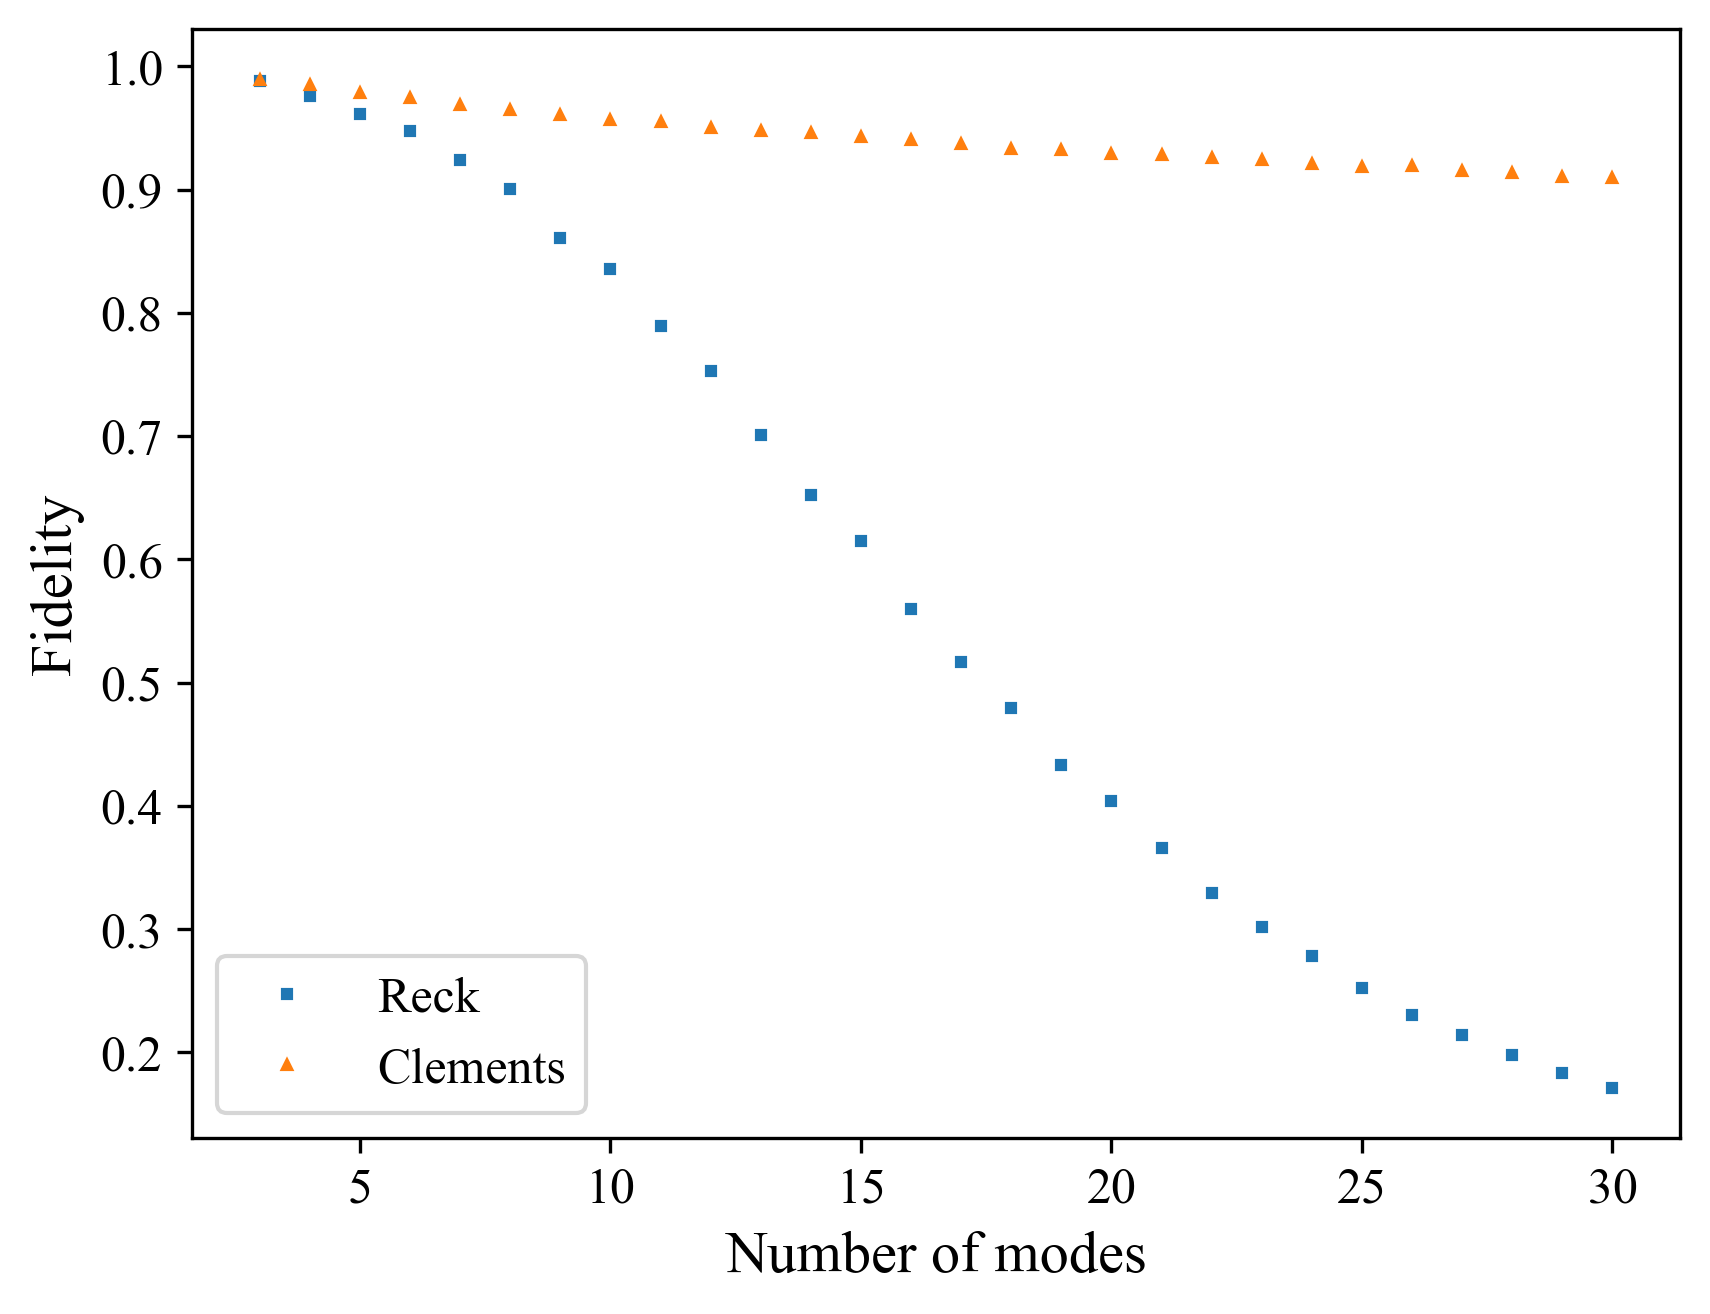

In [8]:
# System Configurations and Parameters
NUM_MODE = 31
LN_dB=-1.5
COUNT = 100

# Buffers to store the data for drawings
fidelity = np.zeros((NUM_MODE, 1))

# Setup for Matplotlib
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "normal"
plt.rcParams["font.size"] = 12
plt.figure(dpi=300)
x = range(3, NUM_MODE)

# Sweep Parameters [Reck]
for i in range(3, NUM_MODE):
    statistic = 0.0
    for _ in range(COUNT):
        mat = np.random.randn(i, i)
        [u, s, v] = np.linalg.svd(mat, full_matrices=True)
        [p, t, a] = decompose_reck(u)
        Ue = reconstruct_reck(p, t, a, LN_dB=LN_dB)
        statistic += np.abs(np.trace(u.conj().T @ Ue) /
                            np.sqrt(i * np.trace(Ue.conj().T @ Ue))) ** 2
    fidelity[i] = statistic / COUNT

# Annotate Setup
y_reck = fidelity[3:NUM_MODE].copy()
plt.plot(x, y_reck, 's', markersize=2)

# Sweep Parameters [Clements]
for i in range(3, NUM_MODE):
    statistic = 0.0
    for _ in range(COUNT):
        mat = np.random.randn(i, i)
        [u, s, v] = np.linalg.svd(mat, full_matrices=True)
        [p, t, a] = decompose_clements(u)
        Ue = reconstruct_clements(p, t, a, LN_dB=LN_dB)
        statistic += np.abs(np.trace(u.conj().T @ Ue) /
                            np.sqrt(i * np.trace(Ue.conj().T @ Ue))) ** 2
    fidelity[i] = statistic / COUNT

# Annotate Setup
y_clements = fidelity[3:NUM_MODE].copy()
plt.plot(x, y_clements, '^', markersize=2)

# Decorate Figures
plt.xlabel('Number of modes', fontsize=14)
plt.ylabel('Fidelity', fontsize=14)
plt.legend(['Reck', 'Clements', 'Our'])

plt.show()